In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Define the path to the zip file
zip_path = "/content/drive/MyDrive/project/archive (3).zip"
extract_path = "/content/archive (3)"

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
!pip install ultralytics opencv-python scikit-learn imbalanced-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.5 MB/s eta 0:00:00


In [ ]:
# ======================================
# 1. Install Dependencies
# ======================================
# !pip install ultralytics opencv-python scikit-learn imbalanced-learn

import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import random
from ultralytics import YOLO

# ======================================
# 2. Dataset Path Setup
# ======================================
dataset_path = "/content/archive (3)/Fabric Defects Dataset/Fabric Defect Dataset"
output_path = "/content/FabricDefect_Prepared"

# ======================================
# 3. Image Preprocessing Function
# ======================================
def preprocess_image(img_path, target_size=(224, 224)):
    img = cv2.imread(img_path)
    if img is None:
        return None

    # Resize
    img = cv2.resize(img, target_size)

    # Noise removal (Gaussian blur)
    img = cv2.GaussianBlur(img, (3, 3), 0)

    # Adaptive histogram equalization (CLAHE)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    return img

# ======================================
# 4. Prepare Dataset (Split into train/val/test with preprocessing)
# ======================================
def prepare_dataset(dataset_path, output_path, test_size=0.1, val_size=0.1):
    classes = os.listdir(dataset_path)
    os.makedirs(output_path, exist_ok=True)

    for split in ["train", "val", "test"]:
        for c in classes:
            os.makedirs(os.path.join(output_path, split, c), exist_ok=True)

    for c in classes:
        class_dir = os.path.join(dataset_path, c)
        if not os.path.isdir(class_dir):
            continue

        img_paths = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]

        # Split train/val/test
        train_paths, test_paths = train_test_split(img_paths, test_size=test_size, random_state=42)
        train_paths, val_paths = train_test_split(train_paths, test_size=val_size/(1-test_size), random_state=42)

        # Save images after preprocessing
        for split, paths in zip(["train", "val", "test"], [train_paths, val_paths, test_paths]):
            for p in paths:
                img = preprocess_image(p)
                if img is not None:
                    out_name = os.path.basename(p)
                    cv2.imwrite(os.path.join(output_path, split, c, out_name), img)

    print("✅ Dataset prepared with preprocessing at:", output_path)

prepare_dataset(dataset_path, output_path)

# ======================================
# 5. Balance Classes in Training Set
# ======================================
def balance_classes(base_path):
    class_counts = {c: len(os.listdir(os.path.join(base_path, c))) for c in os.listdir(base_path)}
    max_count = max(class_counts.values())

    for c, count in class_counts.items():
        diff = max_count - count
        if diff > 0:
            img_files = os.listdir(os.path.join(base_path, c))
            for i in range(diff):
                img = cv2.imread(os.path.join(base_path, c, random.choice(img_files)))
                new_name = f"aug_{i}_{img_files[i % len(img_files)]}"
                cv2.imwrite(os.path.join(base_path, c, new_name), img)

    print("✅ Classes balanced:", {c: len(os.listdir(os.path.join(base_path, c))) for c in os.listdir(base_path)})

balance_classes(os.path.join(output_path, "train"))

# ======================================
# 6. Train YOLOv8 Classification Model
# ======================================
model = YOLO("yolov8s-cls.pt")  # pretrained classification model

model.train(
    data=output_path,   # dataset root (must contain train/, val/, test/)
    epochs=10,
    imgsz=224,
    batch=32,
    workers=4,
    patience=10,
    lr0=1e-3,      # learning rate for fine-tuning
    optimizer="Adam",
    augment=True   # enable augmentations
)

# ======================================
# 7. Validate on Test Set
# ======================================
metrics = model.val(data=os.path.join(output_path, "test"))
print("📊 Test Results:", metrics)

✅ Dataset prepared with preprocessing at: /content/FabricDefect_Prepared
✅ Classes balanced: {'defect free': 1332, 'horizontal': 1332, 'lines': 1332, 'Vertical': 1332, 'hole': 1332, 'stain': 1332}
Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/FabricDefect_Prepared, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yol

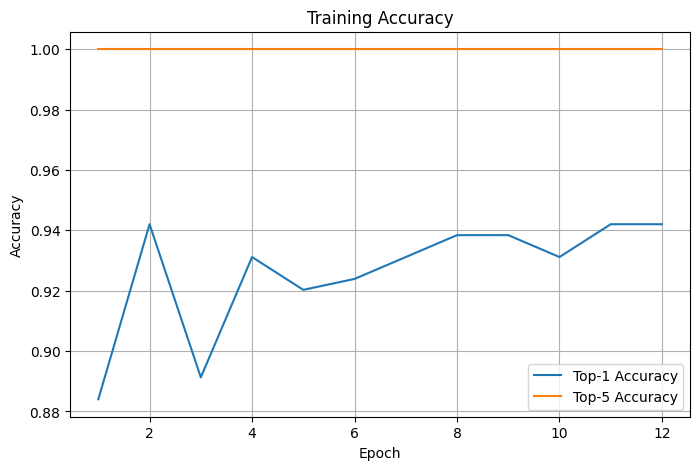

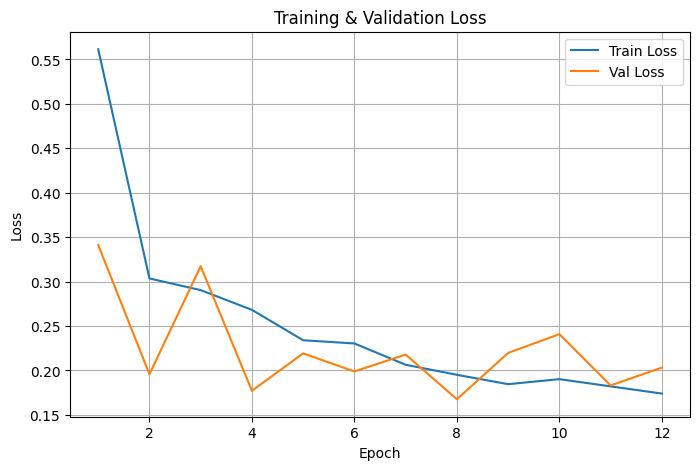

Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8s-cls summary (fused): 30 layers, 5,082,886 parameters, 0 gradients, 12.5 GFLOPs
WARNING ⚠️ Dataset 'split=train' not found at /content/FabricDefect_Prepared/test_split/val/train
Found 117 images in subdirectories. Attempting to split...
Splitting /content/FabricDefect_Prepared/test_split/val (6 classes, 117 images) into 80% train, 20% val...
Split complete in /content/FabricDefect_Prepared/test_split/val_split ✅
train: /content/FabricDefect_Prepared/test_split/val_split/train... found 113 images in 6 classes ✅ 
val: /content/FabricDefect_Prepared/test_split/val_split/val... found 50 images in 6 classes ✅ 
test: None...
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 546.4±554.7 MB/s, size: 38.2 KB)
val: Scanning /content/FabricDefect_Prepared/test_split/val_split/val... 50 images, 0 corrupt: 100% ━━━━━━━━━━━━ 50/50 4.5Kit/s 0.0s
val: New cache created: /content/FabricDefect_Prepared/test_split/v

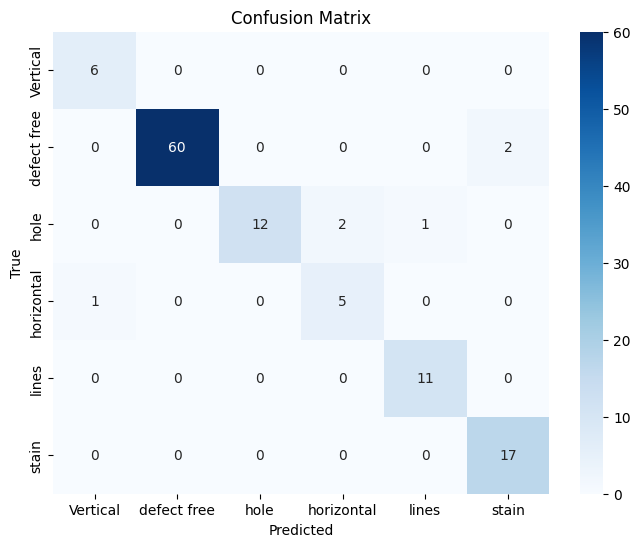

📊 Classification Report:

              precision    recall  f1-score   support

    Vertical       0.86      1.00      0.92         6
 defect free       1.00      0.97      0.98        62
        hole       1.00      0.80      0.89        15
  horizontal       0.71      0.83      0.77         6
       lines       0.92      1.00      0.96        11
       stain       0.89      1.00      0.94        17

    accuracy                           0.95       117
   macro avg       0.90      0.93      0.91       117
weighted avg       0.95      0.95      0.95       117



In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from ultralytics import YOLO

# ======================================
# 1. Load Trained Model
# ======================================
trained_model = YOLO("runs/classify/train/weights/best.pt")

# Where YOLO saves training results
results_dir = "runs/classify/train"
results_file = os.path.join(results_dir, "results.csv")

# ======================================
# 2. Plot Accuracy & Loss Curves
# ======================================
if os.path.exists(results_file):
    df = pd.read_csv(results_file)

    # Accuracy
    plt.figure(figsize=(8,5))
    plt.plot(df["epoch"], df["metrics/accuracy_top1"], label="Top-1 Accuracy")
    if "metrics/accuracy_top5" in df.columns:
        plt.plot(df["epoch"], df["metrics/accuracy_top5"], label="Top-5 Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(results_dir, "accuracy_curve.png"))
    plt.show()

    # Loss
    plt.figure(figsize=(8,5))
    plt.plot(df["epoch"], df["train/loss"], label="Train Loss")
    plt.plot(df["epoch"], df["val/loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(results_dir, "loss_curve.png"))
    plt.show()
else:
    print("⚠️ results.csv not found – train the model first.")

# ======================================
# 3. Prepare Validation/Test Data
# ======================================
# Point to your prepared test folder
test_path = "/content/FabricDefect_Prepared/test_split/val"

# Run validation
results = trained_model.val(data=test_path, save_json=True, save_txt=True)

# ======================================
# 4. Collect Predictions & Ground Truths
# ======================================
y_true, y_pred = [], []
labels = list(trained_model.names.values())

for root, dirs, files in os.walk(test_path):
    if len(files) > 0:
        class_name = os.path.basename(root)
        if class_name in labels:  # ensure it's a real class folder
            for f in files:
                img_path = os.path.join(root, f)
                pred = trained_model(img_path, verbose=False)[0]
                y_true.append(class_name)
                y_pred.append(pred.names[pred.probs.top1])

# ======================================
# 5. Confusion Matrix
# ======================================
cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(results_dir, "confusion_matrix.png"))
plt.show()

# ======================================
# 6. Classification Report
# ======================================
report = classification_report(y_true, y_pred, target_names=labels)
print("📊 Classification Report:\n")
print(report)

# Save report to file
with open(os.path.join(results_dir, "classification_report.txt"), "w") as f:
    f.write(report)


In [ ]:
from ultralytics import YOLO
import os

trained_model = YOLO("runs/classify/train/weights/best.pt")
test_dir = os.path.join(output_path, "test")

for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)

        results_list = trained_model(img_path)
        results = results_list[0]

        results.show()

        # Use the Probs object attributes
        pred_class_idx = results.probs.top1
        pred_class_name = trained_model.names[pred_class_idx]
        pred_prob = results.probs.top1conf.item()

        print(f"Image: {img_file}")
        print(f"Actual Class: {class_name}")
        print(f"Predicted Class: {pred_class_name} ({pred_prob:.2f})")
        print(f"Top 5 Classes: {results.probs.top5}")
        print(f"Top 5 Confidences: {results.probs.top5conf}")
        print("="*50)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import os

weights_path = "/content/runs/classify/train3/weights/best.pt"
print(os.path.exists(weights_path))


True


In [ ]:
from google.colab import files

files.download(weights_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>